# Advanced Computational Techniques for Big Imaging and Signal Data Project

The primary objective of this project is to develop a deep learning model to accurately classify human activities based on sensor data collected from smartphones. This involves analyzing the dataset, preprocessing the data, creating and training a neural network, evaluating its performance, and deploying the model using a Streamlit dashboard.

**Created by Anass Nassiri
Matricola:908475**

First few rows of the training dataset:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad(

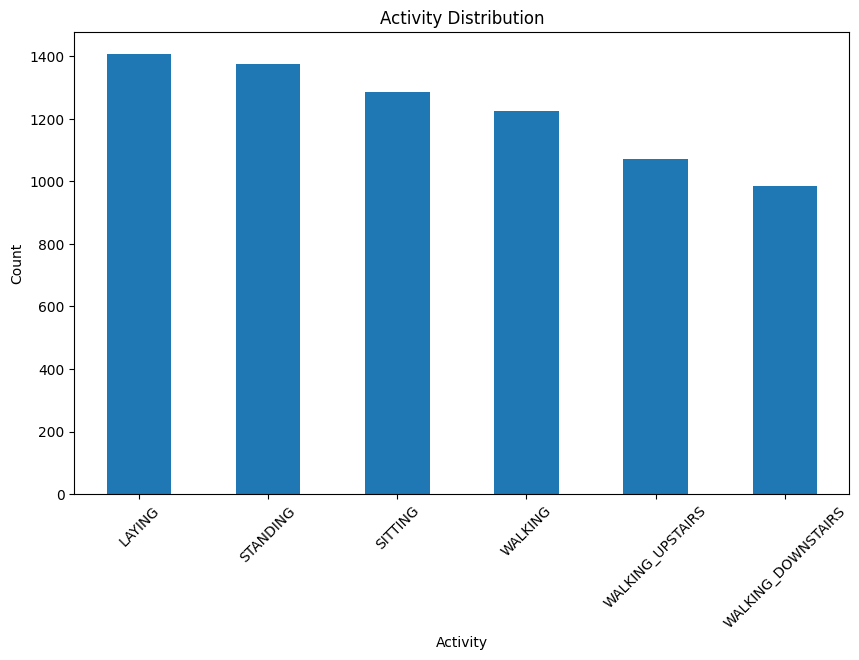

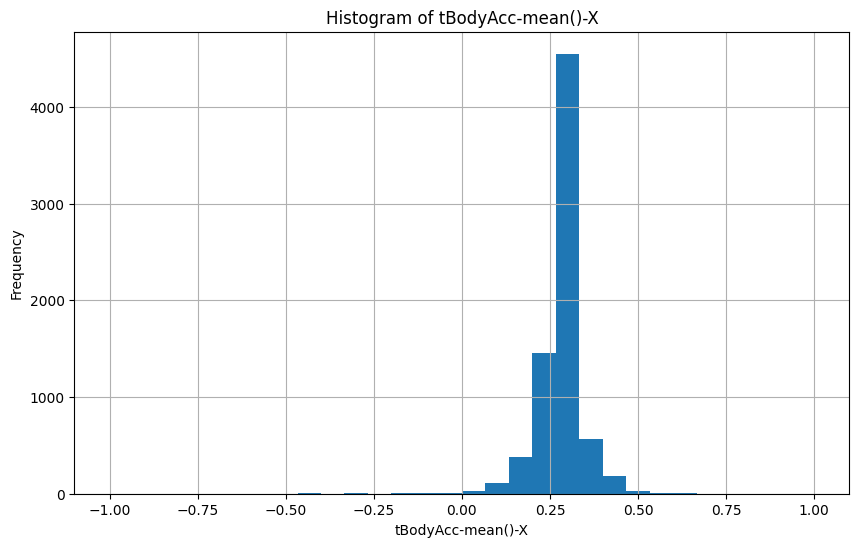

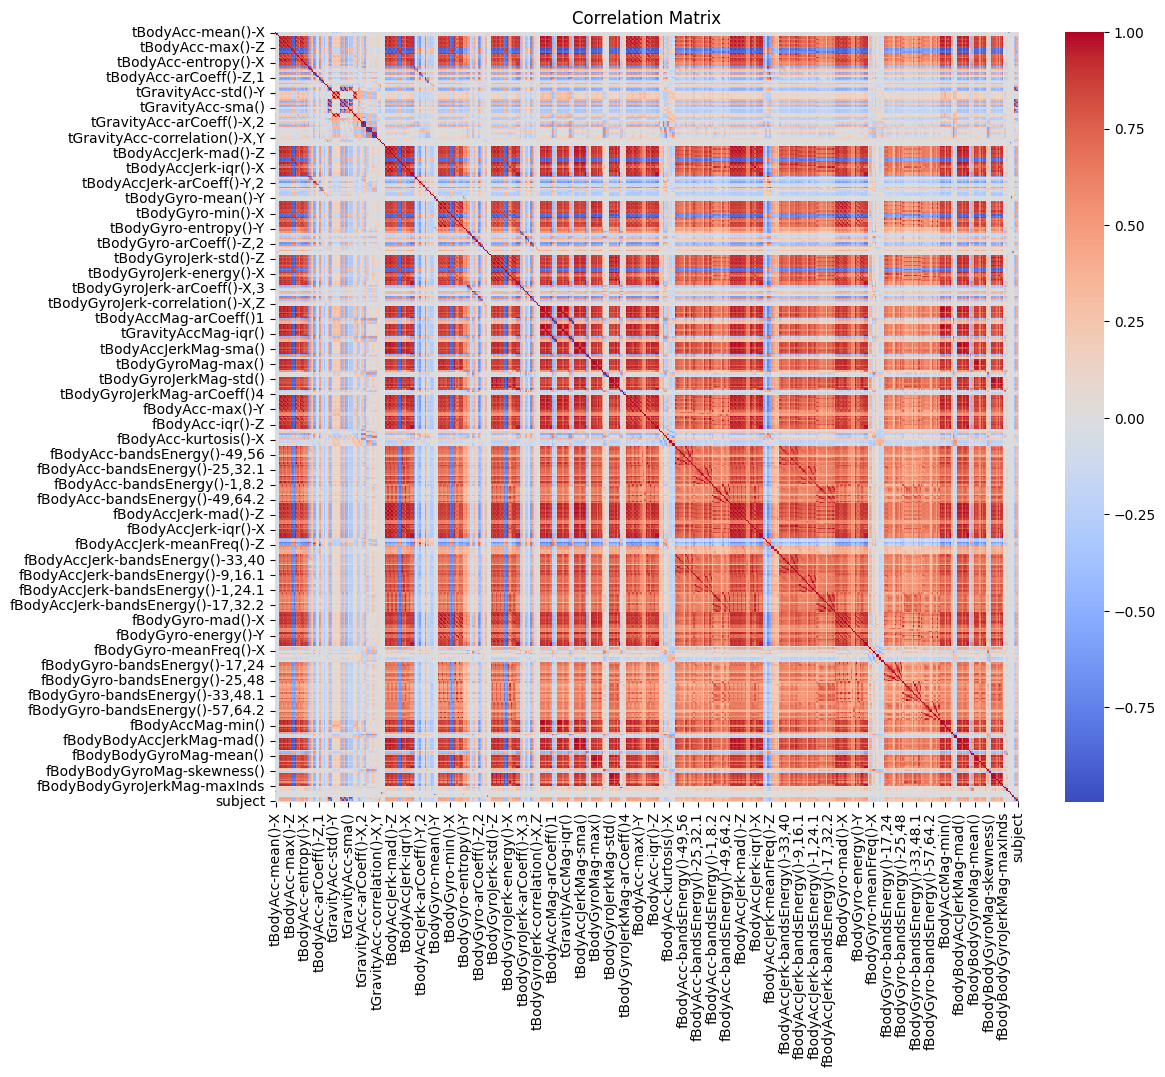


Missing values in the training dataset:
Series([], dtype: int64)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/train.csv')
test = pd.read_csv('/kaggle/input/human-activity-recognition-with-smartphones/test.csv')

# Display the first few rows of the training dataset
print("First few rows of the training dataset:")
print(train.head())

# Dataset information
print("\nTraining dataset information:")
print(train.info())

# Basic statistics of the dataset
print("\nBasic statistics of the training dataset:")
print(train.describe())

# Distribution of activity labels
activity_counts = train['Activity'].value_counts()
print("\nDistribution of activity labels in the training dataset:")
print(activity_counts)

# Visualize the distribution of activity labels
plt.figure(figsize=(10, 6))
activity_counts.plot(kind='bar')
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot histogram of a feature (example feature: 'tBodyAcc-mean()-X')
plt.figure(figsize=(10, 6))
train['tBodyAcc-mean()-X'].hist(bins=30)
plt.title('Histogram of tBodyAcc-mean()-X')
plt.xlabel('tBodyAcc-mean()-X')
plt.ylabel('Frequency')
plt.show()

# Exclude non-numeric columns for the correlation matrix
numeric_features = train.select_dtypes(include=[float, int])

# Correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

# Check for missing values
missing_values = train.isnull().sum()
print("\nMissing values in the training dataset:")
print(missing_values[missing_values > 0])


In [19]:
train_path = '/kaggle/input/human-activity-recognition-with-smartphones/train.csv'
test_path = '/kaggle/input/human-activity-recognition-with-smartphones/train.csv'


**The base model: neura network model**

In [20]:
import torch.nn as nn
# Architecture of  the neural network model
class HARModel(nn.Module):
    def __init__(self):
        super(HARModel, self).__init__()
        self.fc1 = nn.Linear(561, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(label_to_index))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define data loading functions
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.iloc[:, :-2].values
    y_train = train_df['Activity'].values
    X_test = test_df.iloc[:, :-2].values
    y_test = test_df['Activity'].values

    return X_train, y_train, X_test, y_test

def encode_labels(y_train, y_test):
    unique_labels = sorted(list(set(y_train)))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y_train_encoded = [label_to_index[label] for label in y_train]
    y_test_encoded = [label_to_index[label] for label in y_test]

    return torch.tensor(y_train_encoded, dtype=torch.long), torch.tensor(y_test_encoded, dtype=torch.long), label_to_index

def preprocess_data(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    mean = X_tensor.mean(dim=0)
    std = X_tensor.std(dim=0)
    X_tensor = (X_tensor - mean) / std
    return X_tensor, mean, std

# Load and preprocess data

X_train, y_train, X_test, y_test = load_data(train_path, test_path)
X_train, mean, std = preprocess_data(X_train)
X_test = (torch.tensor(X_test, dtype=torch.float32) - mean) / std
y_train, y_test, label_to_index = encode_labels(y_train, y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
model = HARModel()

# Train the model
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
        evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    true_targets = []
    predictions = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.numpy())
            true_targets.extend(labels.numpy())
    print(f'Accuracy: {100 * correct / total:.2f}%')
    accuracy = accuracy_score(true_targets, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_targets, predictions, average='macro')
    return accuracy, precision, recall, f1

train_model(model, train_loader, num_epochs=10)

# Save the model and normalization parameters
model_saving_path='/kaggle/working/har_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'mean': mean,
    'std': std,
    'label_to_index': label_to_index
}, model_saving_path)

Epoch 1/10, Loss: 0.3234045304681944
Accuracy: 95.50%
Epoch 2/10, Loss: 0.09192882947947668
Accuracy: 97.80%
Epoch 3/10, Loss: 0.07706724016157829
Accuracy: 97.95%
Epoch 4/10, Loss: 0.04816831857289957
Accuracy: 98.69%
Epoch 5/10, Loss: 0.05120540301963363
Accuracy: 98.46%
Epoch 6/10, Loss: 0.04788891276263672
Accuracy: 98.37%
Epoch 7/10, Loss: 0.042857112326537786
Accuracy: 99.09%
Epoch 8/10, Loss: 0.04141127920871519
Accuracy: 99.02%
Epoch 9/10, Loss: 0.029219224246765447
Accuracy: 99.08%
Epoch 10/10, Loss: 0.038748453366671404
Accuracy: 99.33%


In [23]:
har_metrics=evaluate_model(model, test_loader)
print(har_metrics)

Accuracy: 99.33%
(0.9933351468988031, 0.993593482247035, 0.9936769832176635, 0.9936293042355132)


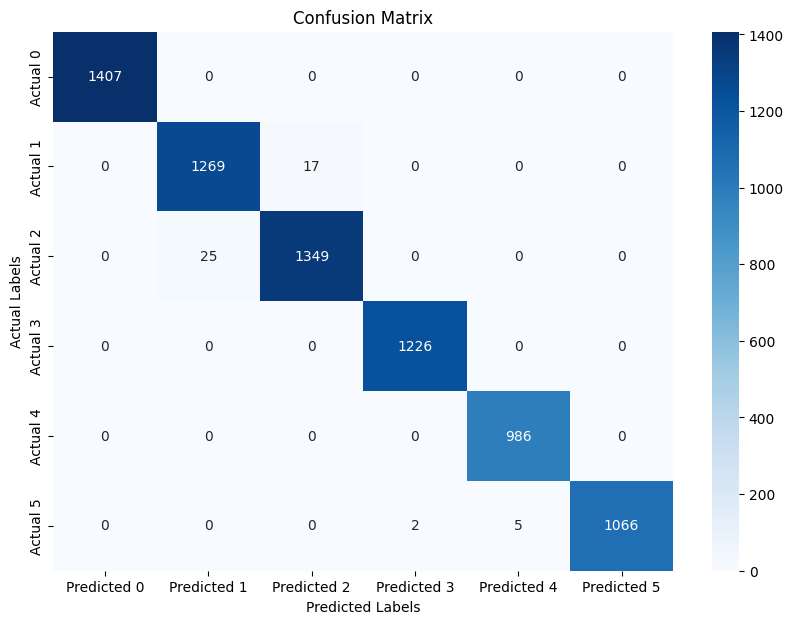

In [26]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Function to get predictions and true labels
def get_predictions_and_labels(model, test_loader,):
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    return true_labels, predictions


# Get true labels and predictions
true_labels, predictions = get_predictions_and_labels(model, test_loader)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {i}' for i in range(6)], columns=[f'Predicted {i}' for i in range(6)])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('confusion_matrix_heatmap.png')
plt.show()


**The pre-proccesing and data loading and traingin and evaluation and architecture of *Cnn* model**

In [27]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the neural network model
class HARCNN(nn.Module):
    def __init__(self):
        super(HARCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * (561 // 2 // 2), 128)  # Adjust based on input size after pooling
        self.fc2 = nn.Linear(128, 6)  # Number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor while keeping batch size consistent
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
# Load and preprocess data
def load_and_preprocess_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    features = train_df.columns[:-2]  
    target = 'Activity'

    label_to_index = {label: idx for idx, label in enumerate(train_df[target].astype('category').cat.categories)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    train_df[target] = train_df[target].map(label_to_index)
    test_df[target] = test_df[target].map(label_to_index)

    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for CNN
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for CNN
    y_test = torch.tensor(y_test, dtype=torch.long)

    mean = X_train.mean(dim=0, keepdim=True)
    std = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader, mean, std, label_to_index, index_to_label

train_loader, test_loader, mean, std, label_to_index, index_to_label = load_and_preprocess_data(train_path, test_path)

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
model = HARCNN()

# Train the model
def train_model(model, train_loader, num_epochs=10):
    har_metrics=0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
        evaluate_model(model, test_loader)
    return har_metrics

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    true_targets = []
    predictions = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.numpy())
            true_targets.extend(labels.numpy())
    print(f'Accuracy: {100 * correct / total:.2f}%')

    accuracy = accuracy_score(true_targets, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_targets, predictions, average='macro')
    return accuracy, precision, recall, f1

train_model(model, train_loader, num_epochs=10)

# Save the model and normalization parameters
model_saving_path='/kaggle/working/har_cnn_model.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'mean': mean,
    'std': std,
    'label_to_index': label_to_index,
    'index_to_label': index_to_label
}, model_saving_path)

Epoch 1/10, Loss: 0.34042331106636836
Accuracy: 95.48%
Epoch 2/10, Loss: 0.08923471348117228
Accuracy: 98.33%
Epoch 3/10, Loss: 0.054118646114416746
Accuracy: 98.78%
Epoch 4/10, Loss: 0.03931619501470224
Accuracy: 99.25%
Epoch 5/10, Loss: 0.028758693443935203
Accuracy: 98.99%
Epoch 6/10, Loss: 0.02254522390278947
Accuracy: 99.31%
Epoch 7/10, Loss: 0.02833819453675381
Accuracy: 95.88%
Epoch 8/10, Loss: 0.02567911698260223
Accuracy: 99.85%
Epoch 9/10, Loss: 0.010283412073951458
Accuracy: 99.74%
Epoch 10/10, Loss: 0.00769735185034654
Accuracy: 99.73%


In [49]:
cnn_metrics=evaluate_model(model, test_loader)
print(cnn_metrics)

Accuracy: 99.73%
(0.9972796517954298, 0.9976087996174079, 0.9974079834110938, 0.9974895959797295)


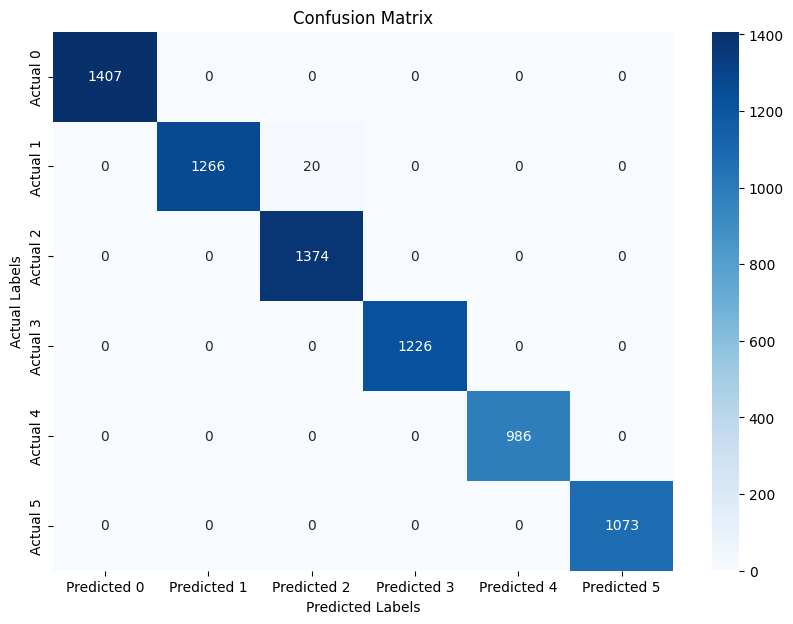

In [50]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Function to get predictions and true labels
def get_predictions_and_labels(model, test_loader,):
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    return true_labels, predictions


# Get true labels and predictions
true_labels, predictions = get_predictions_and_labels(model, test_loader)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {i}' for i in range(6)], columns=[f'Predicted {i}' for i in range(6)])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('confusion_matrix_heatmap.png')
plt.show()


**The pre-proccesing and ata loading and architecture of CnnLstm model**

In [37]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

class HARCnnLstmModel(nn.Module):
    def __init__(self):
        super(HARCnnLstmModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)  # Add more layers as needed
        self.pool = nn.MaxPool1d(2)
        # Calculate the size here as an example, adjust based on your model's architecture
        self.lstm = nn.LSTM(input_size=64 * (561 // 2), hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)  
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        x = self.fc(x)
        return x


In [38]:
# Load and preprocess data
def load_and_preprocess_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    features = train_df.columns[:-2]  
    target = 'Activity'

    label_to_index = {label: idx for idx, label in enumerate(train_df[target].astype('category').cat.categories)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    train_df[target] = train_df[target].map(label_to_index)
    test_df[target] = test_df[target].map(label_to_index)

    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for CNN
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for CNN
    y_test = torch.tensor(y_test, dtype=torch.long)

    mean = X_train.mean(dim=0, keepdim=True)
    std = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader, mean, std, label_to_index, index_to_label

train_loader, test_loader, mean, std, label_to_index, index_to_label = load_and_preprocess_data(train_path, test_path)

In [39]:
model = HARCnnLstmModel()

# Train the model
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
        evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    true_targets = []
    predictions = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.numpy())
            true_targets.extend(labels.numpy())
    print(f'Accuracy: {100 * correct / total:.2f}%')

    accuracy = accuracy_score(true_targets, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_targets, predictions, average='macro')
    return accuracy, precision, recall, f1

train_model(model, train_loader, num_epochs=10)

# Saving the model and normalization parameters
model_saving_path='/kaggle/working/har_CnnLstm_model.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'mean': mean,
    'std': std,
    'label_to_index': label_to_index,
    'index_to_label': index_to_label
}, model_saving_path)

Epoch 1/10, Loss: 0.9618855854739313
Accuracy: 74.92%
Epoch 2/10, Loss: 0.5197614053021307
Accuracy: 83.13%
Epoch 3/10, Loss: 0.40533266883829366
Accuracy: 85.47%
Epoch 4/10, Loss: 0.4529934728923051
Accuracy: 85.42%
Epoch 5/10, Loss: 0.3248841941356659
Accuracy: 87.27%
Epoch 6/10, Loss: 0.2873548577013223
Accuracy: 90.00%
Epoch 7/10, Loss: 0.2542845992938332
Accuracy: 91.76%
Epoch 8/10, Loss: 0.25236060412033745
Accuracy: 90.94%
Epoch 9/10, Loss: 0.23221504053343897
Accuracy: 92.02%
Epoch 10/10, Loss: 0.21242691693098648
Accuracy: 93.04%


In [42]:
cnn_lstm_metrics =evaluate_model(model, test_loader)

Accuracy: 93.04%


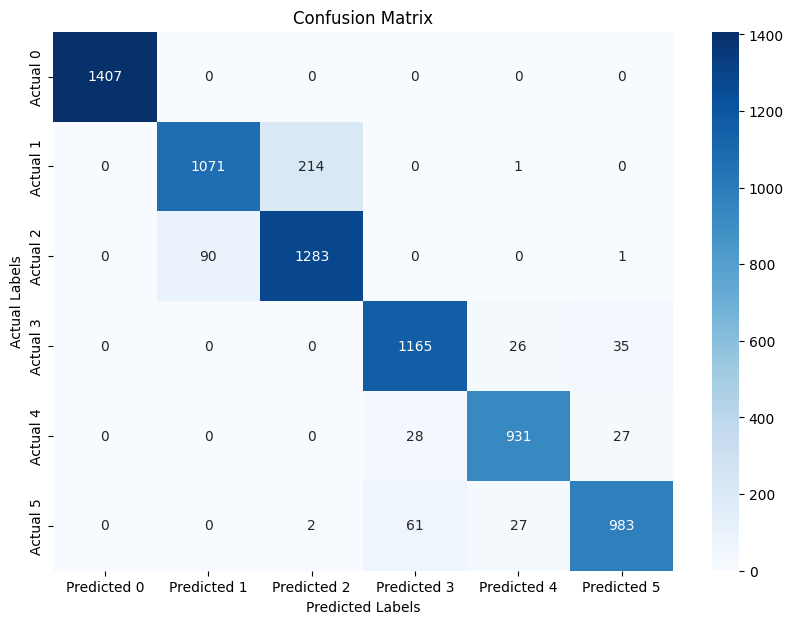

In [43]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Function to get predictions and true labels
def get_predictions_and_labels(model, test_loader,):
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    return true_labels, predictions


# Get true labels and predictions
true_labels, predictions = get_predictions_and_labels(model, test_loader)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {i}' for i in range(6)], columns=[f'Predicted {i}' for i in range(6)])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('confusion_matrix_heatmap.png')
plt.show()


HARModel Performance: (0.9933351468988031, 0.993593482247035, 0.9936769832176635, 0.9936293042355132)
HARCNN Performance: (0.9972796517954298, 0.9976087996174079, 0.9974079834110938, 0.9974895959797295)
HARCnnLstmModel Performance: (0.9303590859630033, 0.9320599814696516, 0.9295286215475924, 0.9300851698021249)


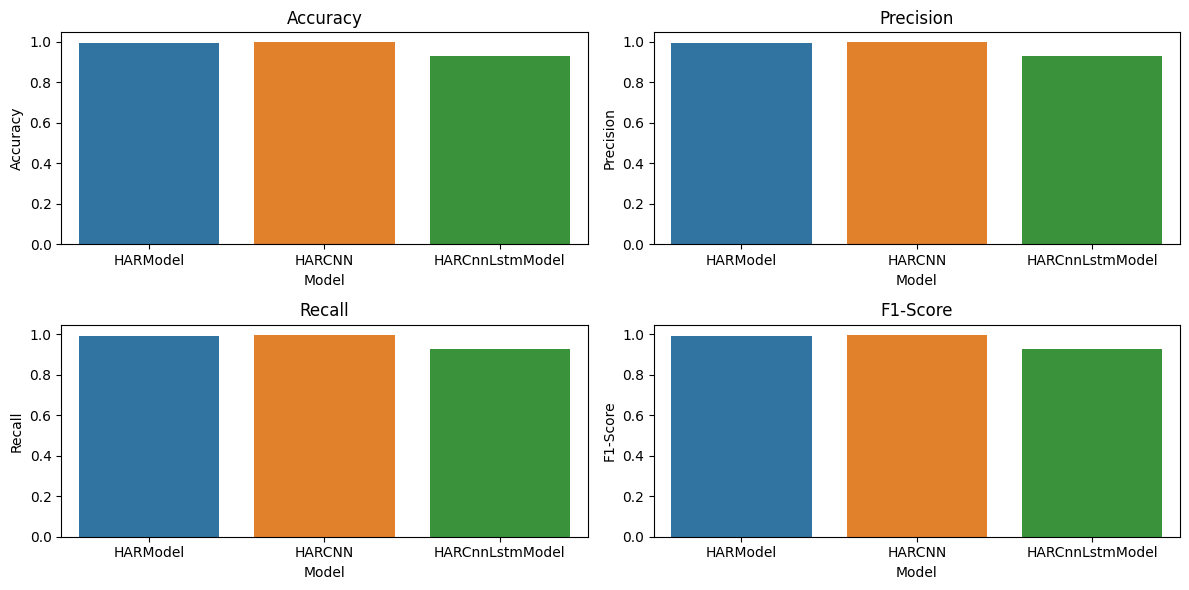

In [51]:
# Print performance
print(f'HARModel Performance: {har_metrics}')
print(f'HARCNN Performance: {cnn_metrics}')
print(f'HARCnnLstmModel Performance: {cnn_lstm_metrics}')

# Prepare data for plotting
metrics = {
    'Model': ['HARModel', 'HARCNN', 'HARCnnLstmModel'],
    'Accuracy': [har_metrics[0], cnn_metrics[0], cnn_lstm_metrics[0]],
    'Precision': [har_metrics[1], cnn_metrics[1], cnn_lstm_metrics[1]],
    'Recall': [har_metrics[2], cnn_metrics[2], cnn_lstm_metrics[2]],
    'F1-Score': [har_metrics[3], cnn_metrics[3], cnn_lstm_metrics[3]]
}

metrics_df = pd.DataFrame(metrics)

# Plotting function
def plot_metrics(metrics_df):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=metrics_df)
    plt.title('Accuracy')

    plt.subplot(2, 2, 2)
    sns.barplot(x='Model', y='Precision', data=metrics_df)
    plt.title('Precision')

    plt.subplot(2, 2, 3)
    sns.barplot(x='Model', y='Recall', data=metrics_df)
    plt.title('Recall')

    plt.subplot(2, 2, 4)
    sns.barplot(x='Model', y='F1-Score', data=metrics_df)
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

# Plot performance metrics
plot_metrics(metrics_df)

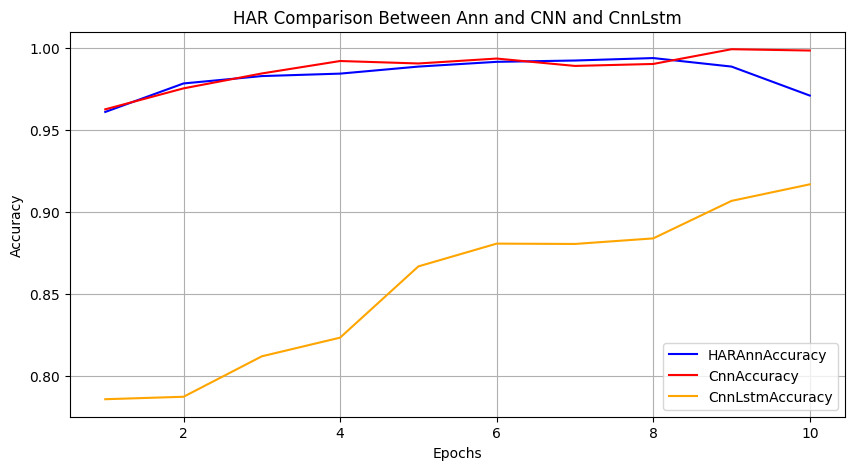

In [52]:
import matplotlib.pyplot as plt
AnnAccuracy=[0.9610,0.9784,0.9829,0.9844,0.9887,0.9916,0.9924,0.9939,0.9887,0.971]
CnnAccuracy=[0.9626,0.9754,0.9845,0.9921,0.9906,0.9936,0.9891,0.9903,0.9993,0.9985]
CnnLstmAccuracy=[0.7856,0.7871,0.8118,0.8232,0.8667,0.8806,0.8804,0.8838,0.9067,0.9168]
epochs = range(1, 11)

plt.figure(figsize=(10, 5))
plt.plot(epochs, AnnAccuracy, label='HARAnnAccuracy', color='blue')
plt.plot(epochs, CnnAccuracy, label='CnnAccuracy', color='red')
plt.plot(epochs, CnnLstmAccuracy, label='CnnLstmAccuracy', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('HAR Comparison Between Ann and CNN and CnnLstm')
plt.legend()
plt.grid(True)
plt.show()